In [261]:
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from transformers import pipeline
import os
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import pandas as pd
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain.chains import RetrievalQA
from langchain_openai import OpenAI

pd.set_option('display.float_format', '{:.2f}'.format)

In [262]:
app_df = pd.read_csv('googleplaystore.csv')
app_df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.10,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.90,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.70,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.50,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.30,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [263]:
review_df = pd.read_csv('googleplaystore_user_reviews.csv')
print(review_df.describe())
print(review_df.head())

       Sentiment_Polarity  Sentiment_Subjectivity
count            37432.00                37432.00
mean                 0.18                    0.49
std                  0.35                    0.26
min                 -1.00                    0.00
25%                  0.00                    0.36
50%                  0.15                    0.51
75%                  0.40                    0.65
max                  1.00                    1.00
                     App                                  Translated_Review  \
0  10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
1  10 Best Foods for You    This help eating healthy exercise regular basis   
2  10 Best Foods for You                                                NaN   
3  10 Best Foods for You         Works great especially going grocery store   
4  10 Best Foods for You                                       Best idea us   

  Sentiment  Sentiment_Polarity  Sentiment_Subjectivity  
0  Positive      

## Part 1: Data Preprocessing and Visualisation
### A. Removing the columns which are not required for the analysis
#### Todo: Most downloaded apps by category, Highest Rated apps by Category, Average rating by number of installs, What are some family apps?

In [264]:
print('Size of the dataset before preprocessing: ', app_df.shape[0])
app_df = app_df[app_df['Size'].str.endswith('M')]
app_df = app_df[app_df['Size'] != 'Varies with device']
app_df['Size'] = app_df['Size'].str.replace('M', '').astype(float)
app_df['Installs'] = app_df['Installs'].str.replace(',', '').str.replace('+', '').astype(int)
app_df['Price'] = app_df['Price'].str.replace('$', '').astype(float)
app_df = app_df.drop(columns=['Android Ver', 'Current Ver', 'Last Updated'])
print('Size of the dataset after preprocessing: ', app_df.shape[0])

print('Size of the reviews dataset before preprocessing: ', review_df.shape[0])
review_df = review_df.drop_duplicates()
review_df = review_df.dropna()
review_df['SENTIMENT'] = review_df['Sentiment'].str.strip().str.upper()
print('Size of the reviews dataset after preprocessing: ', review_df.shape[0])
review_df = review_df.reset_index(drop=True)


Size of the dataset before preprocessing:  10841
Size of the dataset after preprocessing:  8829
Size of the reviews dataset before preprocessing:  64295
Size of the reviews dataset after preprocessing:  29692


### B. Some Application Data Visualization

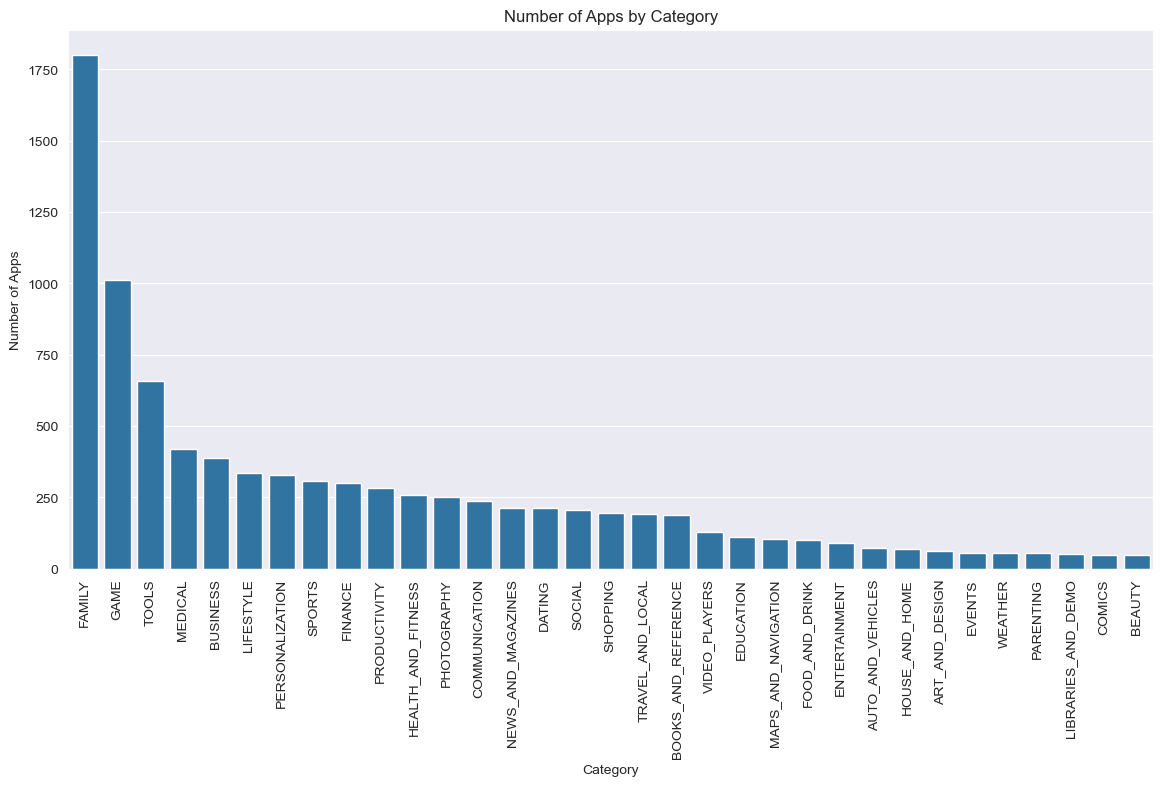


 Category wise information
╒════╤═════════════════════╤══════════════════╤═══════════════════╕
│    │ Category            │   Average_Rating │ Median_Installs   │
╞════╪═════════════════════╪══════════════════╪═══════════════════╡
│  0 │ EVENTS              │          4.46757 │ 1,000             │
├────┼─────────────────────┼──────────────────┼───────────────────┤
│  1 │ EDUCATION           │          4.39167 │ 1,000,000         │
├────┼─────────────────────┼──────────────────┼───────────────────┤
│  2 │ ART_AND_DESIGN      │          4.36102 │ 100,000           │
├────┼─────────────────────┼──────────────────┼───────────────────┤
│  3 │ PARENTING           │          4.34773 │ 100,000           │
├────┼─────────────────────┼──────────────────┼───────────────────┤
│  4 │ PERSONALIZATION     │          4.33672 │ 10,000            │
├────┼─────────────────────┼──────────────────┼───────────────────┤
│  5 │ LIBRARIES_AND_DEMO  │          4.32941 │ 100,000           │
├────┼──────────────

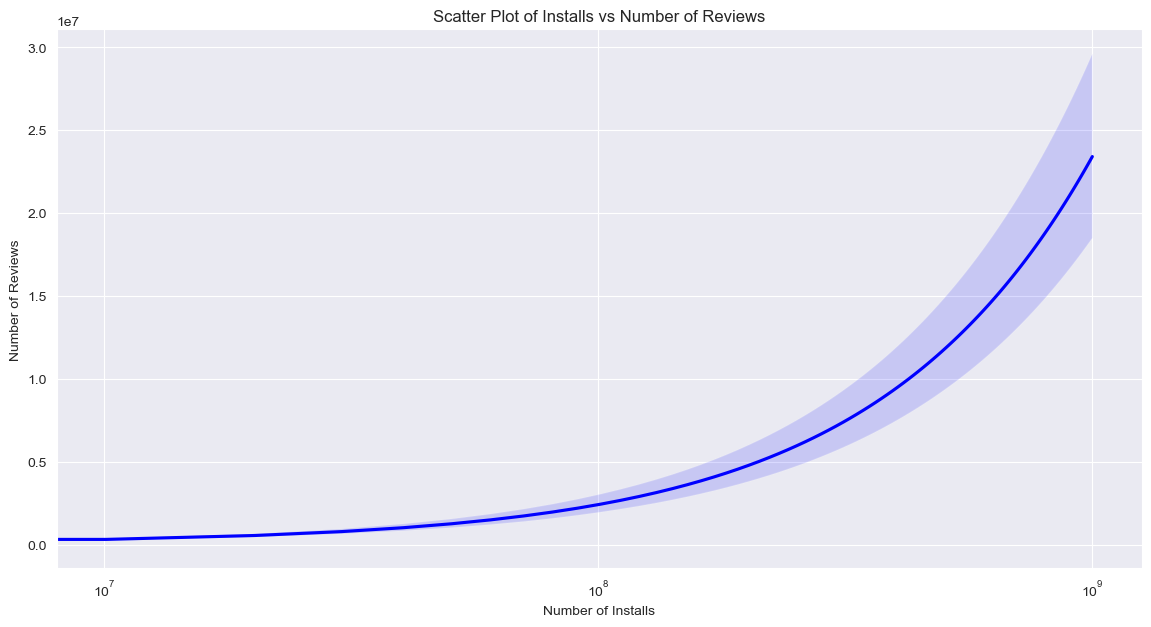

  App Type  Count  Average Rating
0     Free   8175            4.17
1     Paid    654            4.27


In [265]:
category_counts = app_df['Category'].value_counts()

plt.figure(figsize=(14, 7))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Number of Apps by Category')
plt.xlabel('Category')
plt.ylabel('Number of Apps')
plt.xticks(rotation=90)
plt.show()

category_stats = app_df.groupby('Category').agg(
    Average_Rating=('Rating', 'mean'),
    Median_Installs=('Installs', 'median')
).sort_values(by='Average_Rating', ascending=False)

category_stats = category_stats.reset_index()
category_stats['Median_Installs'] = category_stats['Median_Installs'].apply(lambda x: '{:,}'.format(int(x)))
print(category_stats.style.format(precision=3, thousands=".", decimal=",").format_index(str.upper, axis=1))

print("\n Category wise information")
print(tabulate(category_stats, headers='keys', tablefmt='fancy_grid'))

app_df['Installs'] = pd.to_numeric(app_df['Installs'], errors='coerce')
app_df['Reviews'] = pd.to_numeric(app_df['Reviews'], errors='coerce')
app_df = app_df.dropna(subset=['Installs', 'Reviews'])
plt.figure(figsize=(14, 7))
sns.regplot(data=app_df, x='Installs', y='Reviews', scatter=False, color='blue')
plt.title('Scatter Plot of Installs vs Number of Reviews')
plt.xlabel('Number of Installs')
plt.ylabel('Number of Reviews')
plt.xscale('log')
plt.show()

app_df['Rating'] = pd.to_numeric(app_df['Rating'], errors='coerce')
app_df['App Type'] = app_df['Price'].apply(lambda x: 'Free' if x == 0 or x == 0.0 else 'Paid')

app_type_counts = app_df['App Type'].value_counts()
average_ratings = app_df.groupby('App Type')['Rating'].mean()  # Example calculation

summary_table = pd.DataFrame({
    'App Type': app_type_counts.index,
    'Count': app_type_counts.values,
    'Average Rating': average_ratings.values
})

print(summary_table)


## Part 2: Sentiment Analysis


### A. Analyze distribution of sentiments

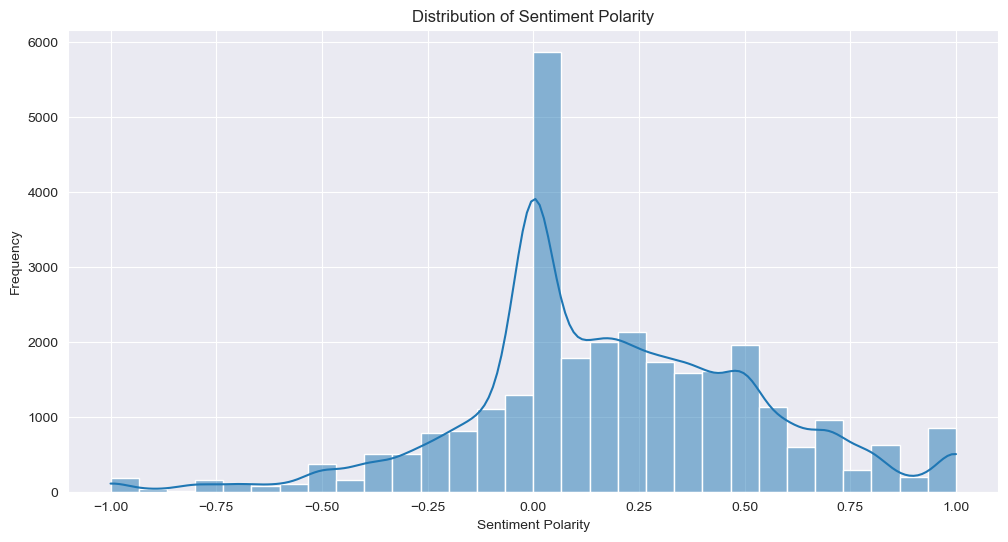

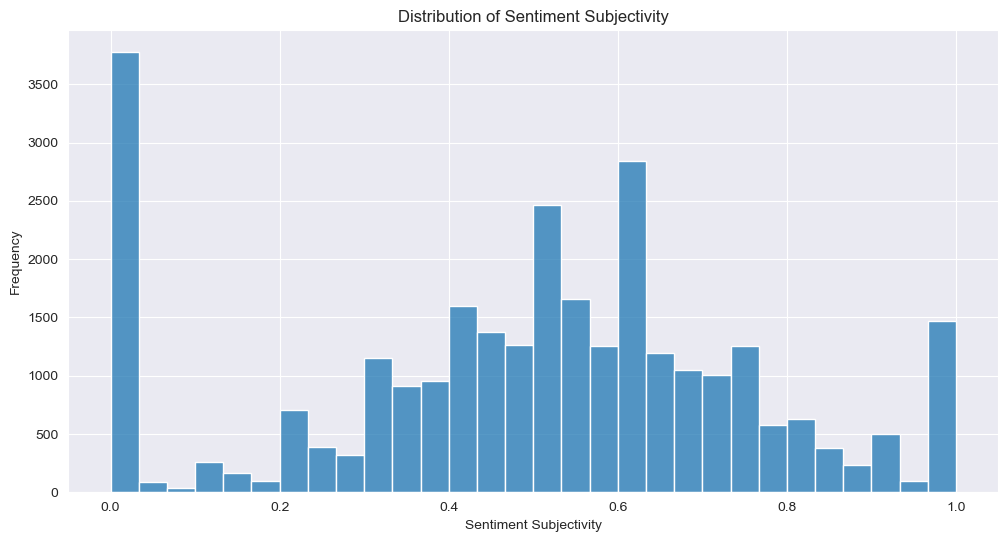

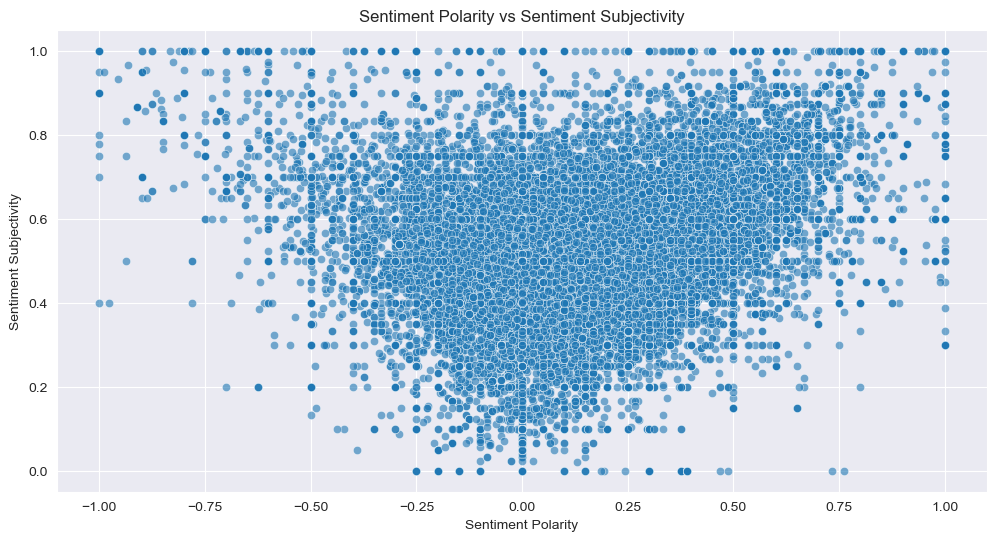

In [266]:
review_df['Sentiment_Polarity'] = pd.to_numeric(review_df['Sentiment_Polarity'], errors='coerce')
review_df['Sentiment_Subjectivity'] = pd.to_numeric(review_df['Sentiment_Subjectivity'], errors='coerce')

plt.figure(figsize=(12, 6))
sns.histplot(review_df['Sentiment_Polarity'], kde=True, bins=30)
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(review_df['Sentiment_Subjectivity'], bins=30)
plt.title('Distribution of Sentiment Subjectivity')
plt.xlabel('Sentiment Subjectivity')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=review_df, x='Sentiment_Polarity', y='Sentiment_Subjectivity', alpha=0.6)
plt.title('Sentiment Polarity vs Sentiment Subjectivity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Sentiment Subjectivity')
plt.show()

### B. Compare sentiments of a random reviews by BERT vs LLM

In [267]:
review_df = review_df.reset_index()
random_sample = review_df[['index', 'Translated_Review', 'SENTIMENT']].dropna().sample(n=50, random_state=42)
random_reviews = random_sample['Translated_Review'].astype(str).tolist()
label_mapping = {
    'LABEL_0': 'NEGATIVE',
    'LABEL_1': 'NEUTRAL',
    'LABEL_2': 'POSITIVE'
}
sentiment_analyzer = pipeline('sentiment-analysis', framework='tf', model='cardiffnlp/twitter-roberta-base-sentiment')
sentiment_results = sentiment_analyzer(random_reviews)
random_sample['ROBERTA_SENTIMENT'] = [label_mapping[result['label']] for result in sentiment_results]

os.environ["OPENAI_API_KEY"] = "Won't leak my API key. Nope. Not gonna happen. No way. No how. Not on my watch."
model = ChatOpenAI(model="gpt-4o")

prompt_template = ChatPromptTemplate(
    [
        ("system",
         "Determine the sentiment of each review and respond only with one word for each: POSITIVE, NEGATIVE, or NEUTRAL."),
        ("human", "\n".join([f"{idx + 1}. {review}" for idx, review in enumerate(random_sample['Translated_Review'])]))
    ]
)

batch_prompt = prompt_template.invoke({})
response = model.invoke(batch_prompt)
responses = response.content.strip().split('\n')
random_sample['LLM_SENTIMENT'] = [resp.split('. ')[-1] for resp in responses]

random_sample

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Device set to use 0


,index,Translated_Review,SENTIMENT,ROBERTA_SENTIMENT,LLM_SENTIMENT
18356,18356,I open it in white. Uninstalled and installed ...,NEUTRAL,NEUTRAL,NEUTRAL
25073,25073,This show accurate amount balance keep showing...,NEGATIVE,NEGATIVE,NEGATIVE
18998,18998,The totally disconnected website. No linkage a...,NEGATIVE,NEGATIVE,NEGATIVE
14028,14028,One best app.i started also like graphic .we s...,POSITIVE,POSITIVE,POSITIVE
15918,15918,I really like digg pure garbage. Trying watch ...,NEGATIVE,NEGATIVE,NEGATIVE
13315,13315,Too many ads,POSITIVE,NEGATIVE,NEGATIVE
1921,1921,"Stuck , buffering",NEUTRAL,NEGATIVE,NEGATIVE
22353,22353,I downloaded game wroe review unlock new chara...,NEGATIVE,NEUTRAL,NEUTRAL
16858,16858,My kids favorite Dr. Panda game Such cute game...,POSITIVE,POSITIVE,POSITIVE
5572,5572,Great,POSITIVE,POSITIVE,POSITIVE


In [268]:
random_sample['ROBERTA_SENTIMENT'] = random_sample['ROBERTA_SENTIMENT'].str.strip().str.upper()
random_sample['LLM_SENTIMENT'] = random_sample['LLM_SENTIMENT'].str.strip().str.upper()
random_sample['Agreement'] = random_sample['ROBERTA_SENTIMENT'] == random_sample['LLM_SENTIMENT']

print('Agreement between ROBERTA and LLM:', random_sample['Agreement'].mean())
print('Number of disagreements:', (~random_sample['Agreement']).sum())

random_sample[random_sample['Agreement'] == False]


Agreement between ROBERTA and LLM: 0.84
Number of disagreements: 8


,index,Translated_Review,SENTIMENT,ROBERTA_SENTIMENT,LLM_SENTIMENT,Agreement
21468,21468,Have played game forever seems. The longer pla...,POSITIVE,POSITIVE,NEUTRAL,False
27339,27339,Play button sometimes dont apply When I tried ...,POSITIVE,NEUTRAL,NEGATIVE,False
26498,26498,"This trash I'm from, 7 restaurants available 5...",POSITIVE,NEUTRAL,NEGATIVE,False
18486,18486,It's good except passes get,POSITIVE,POSITIVE,NEUTRAL,False
12166,12166,This ok... least chat free much better apps! I...,POSITIVE,NEUTRAL,NEGATIVE,False
12621,12621,This game fun something matchmaking. You fight...,NEGATIVE,NEUTRAL,NEGATIVE,False
21724,21724,Not bad...,POSITIVE,POSITIVE,NEUTRAL,False
2276,2276,Need new icon new look fix issue ad,POSITIVE,NEUTRAL,NEGATIVE,False


### Comments of Disagreement Between ROBERTA and LLM Sentiment

The disagreement between the **ROBERTA Sentiment** and the **LLM Sentiment** classifications in the dataset could be because of the following reasons:

#### 1. **Word-wise interpretations**
- ROBERTA see,s to focus on individual words and phrases to determine sentiment, which may lead to a more literal interpretation.
- LLM: Has a deeper understanding of context and can infer sentiment based on the overall meaning of the text.

##### Eg:
- **Sentence**: "I love game, many ads. I even get ads phone use. Its annoying, fun game."
  - ROBERTA: `POSITIVE`
  - LLM: `NEUTRAL`

---

#### 2. **Handling of inverted Sentiments**
- ROBERTA may overemphasis one aspect in a sentence (especially for inverted sentiments).
- LLMs tend to balance conflicting sentiments.

##### Example:
- **Sentence**: "Not bad..."
  - ROBERTA: `POSITIVE`
  - LLM: `NEUTRAL`

---

#### 3. **Sentence Structure/Grammar and Context**
- ROBERTA is struggling with Grammar.
- LLMs are generally better at understanding such texts due to their ability to infer context.

##### Example:
- **Sentence**: "Have played game forever seems. The longer play, harder gets win. Loved everything til started changing fish. I love natural real life fish. Don't like new fish enjoy playing more. On 603 level thinking quitting. Doesn't calm more. Still go first aquariums play I enjoyed them. Please knock new type fish. Make new game leave mine alone please Thanks."
  - ROBERTA: `POSITIVE`
  - LLM: `NEUTRAL`

---

### Conclusion
**IN MY FINDINGS**, LLMs beat Sentiment Analysis models in every aspect. Part of the reason could be because of the varying data that both these models are trained on. `cardiffnlp/twitter-roberta-base-sentiment` is trained on Twitter data, and other BERT models are also similarly trained on Tweets, Books, and/or Wikipedia pages. However, the data scraped by OpenAI is, well, **HUGE!** Hence, the difference and better performance. Also, most of the difference are one step differences (`POSITIVE` vs `NEUTRAL` **OR** `NEUTRAL` vs `POSTIVE`). So they do not disagree entirely (in most disagreement cases).

## Part 3: Insights and guidance

### A. Combine data of both the datasets and get insights from LLM model

In [269]:
review_grouped = review_df.groupby('App').agg({
    'Translated_Review': list
}).reset_index()
review_grouped['Translated_Reviews'] = review_grouped['Translated_Review'].apply(
    lambda reviews: ', '.join([f"'{review}'" for review in reviews])
)
merged_df = pd.merge(app_df, review_grouped, on='App', how='inner')
print("Number of application with reviews: ", merged_df.shape[0])

Number of application with reviews:  806


In [270]:
embedding_model = OpenAIEmbeddings()
merged_df['Context'] = merged_df.apply(
    lambda row: f"App Name: {row['App']}\n"
                f"Category: {row['Category']}\n"
                f"Rating: {row['Rating']}\n"
                f"Reviews: {', '.join(row['Translated_Review'][:5])}",
    axis=1
)

In [271]:
documents = merged_df['Context'].tolist()
if not os.path.exists("chroma_db"):
    vector_store = Chroma(
        embedding_function=embedding_model,
        persist_directory="chroma_db"
    )
    vector_store.add_texts(texts=documents)
else: vector_store =Chroma(persist_directory="chroma_db", embedding_function=embedding_model)

In [272]:
qa_chain = RetrievalQA.from_chain_type(
    llm=OpenAI(),
    chain_type="stuff",
    retriever=vector_store.as_retriever()
)
query = ("What is the first app?")
docs = vector_store.as_retriever().get_relevant_documents(query)
response = qa_chain.run(query)
print(response)

 All Social Networks

